In [1]:
import esm
import torch
from time import time

In [2]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
from Bio import SeqIO, Phylo
import pandas as pd
from scipy.spatial.distance import squareform, pdist, cdist
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

torch.set_grad_enabled(False)

In [3]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

def Seq_tuples_to_fasta(sequences, file_name):
    MSA_SeqRecords = [SeqRecord(Seq(record[1]), id = record[0], name= record[0], description= record[0]) for record in sequences]
    with open(f"{file_name}.fasta", "w") as output_handle:
        SeqIO.write(MSA_SeqRecords, output_handle, "fasta")

In [4]:
MSA_filename = "./data/protein-families-msa-seed/PF00004_seed.fasta"

In [5]:
all_seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(MSA_filename, "fasta")]

In [27]:
tree_path = "./data/seed-trees/PF00004_seed.newick"
tree = Phylo.read(tree_path,"newick")
tree.root_at_midpoint()

In [30]:
tree.get_terminals()


[Clade(branch_length=0.20468, name='ORC1_YEAST/475-621'),
 Clade(branch_length=0.09916, name='ORC1_KLULA/467-613'),
 Clade(branch_length=0.42931, name='ORC1_CANAX/424-569'),
 Clade(branch_length=0.3106, name='ORC1_SCHPO/364-509'),
 Clade(branch_length=0.11649, name='P70049_XENLA/556-701'),
 Clade(branch_length=0.33285, name='ORC1_DROME/594-739'),
 Clade(branch_length=0.19641, name='ORC1A_ARATH/462-610'),
 Clade(branch_length=0.192, name='BCS1_SCHPO/245-370'),
 Clade(branch_length=0.1973, name='BCS1_YEAST/263-388'),
 Clade(branch_length=0.32479, name='Q20755_CAEEL/246-375'),
 Clade(branch_length=0.87229, name='AATP4_ARATH/234-353'),
 Clade(branch_length=1.90117, name='O83350_TREPA/346-472'),
 Clade(branch_length=0.87956, name='YJOB_BACSU/223-337'),
 Clade(branch_length=0.36587, name='YCF2_MARPO/1400-1545'),
 Clade(branch_length=0.70586, name='YCF2_PINTH/1373-1527'),
 Clade(branch_length=1.99723, name='PEX6_SCHPO/425-554'),
 Clade(branch_length=1.28169, name='P96281_MYCTU/250-370'),
 Cla

In [ ]:
# torch.cuda.empty_cache()

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
# model = model.to(device)
# batch_converter = alphabet.get_batch_converter()
# model.eval() 

# _,_,batch_tokens = batch_converter([sampled_MSA_tuples])
# batch_tokens = batch_tokens.to(device)

# logits = model(batch_tokens, need_head_weights = False, return_contacts = False)["logits"]

# softmax = torch.nn.Softmax(dim=-1)
# probs = softmax(logits).cpu().numpy()

# numpy_tokens = batch_tokens.cpu().numpy()
# MSA_prob_matrix = np.zeros((probs.shape[1],probs.shape[2]))
# for i in range(probs.shape[1]):
#     for j in range(probs.shape[2]):
#         char_index = int(numpy_tokens[0,i,j])
#         MSA_prob_matrix[i,j] = probs[0,i,j,char_index]

In [ ]:
# base_state_dict = {}
# for name, param in model.state_dict().items():
#     if not (name.startswith("lm_head") or name.startswith("contact_head")):
#         base_state_dict[name] = param

# lm_head_state_dict = {}
# for name, param in model.state_dict().items():
#     if name.startswith("lm_head") or name == "embed_tokens.weight":
#         lm_head_state_dict[name] = param

# from msa_light import MSATransformer
# from msa_lm_head import MSATransformer_lm_head
# from tokenization import Vocab

# msa_light = MSATransformer(vocab = Vocab.from_esm_alphabet(alphabet))
# msa_light = msa_light.to(device)

# msa_lm_head = MSATransformer_lm_head(vocab = Vocab.from_esm_alphabet(alphabet))
# msa_lm_head = msa_lm_head.to(device)

# msa_light.load_state_dict(base_state_dict, strict=True)
# msa_lm_head.load_state_dict(lm_head_state_dict, strict=True)

In [8]:
%load_ext cython

In [12]:
%%cython -a

# cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX
from libc.stdlib cimport rand, srand
from posix.stdlib cimport drand48
from generation_sequence cimport exp
from libc.time cimport time
from cython.parallel import prange

cdef class Creation_MSA_Generation:

    cdef double[:,::1] Field
    cdef double[:,:,:,::1] Coupling
    cdef int Number_state_spin
    cdef int Number_of_Node
    cdef int seq_counter
    
    def __init__(self, double[:,::1] Field, double[:,:,:,::1] Coupling ):

        self.Number_of_Node = np.intc(Field.shape[0])
        self.Number_state_spin = np.intc(Field.shape[1])
        self.Field = Field
        self.Coupling = Coupling
        self.seq_counter = 0
        srand(<unsigned int>time(NULL))
        
    def msa_no_phylo(self, int n_sequences, int n_flip_equi):
        cdef:
            int index_msa
            char[:,::1] msa = np.random.randint(0,high=self.Number_state_spin, 
                                size = (n_sequences,self.Number_of_Node)
                                ,dtype = np.int8)
        for index_msa in prange(msa.shape[0],nogil=True,schedule='dynamic'):
            self.mcmc(n_flip_equi, msa[index_msa])
        return np.asarray(msa)
                
    def msa_phylo(self, int n_generations, int n_mutations_generation, int flip_before_start):
        cdef:
            char[::1] l_spin = np.random.randint(0,
                                                 high=self.Number_state_spin
                                                 ,size = ( self.Number_of_Node)
                                                ,dtype = np.int8)
            char[:,::1] msa = np.zeros((int(2**n_generations),self.Number_of_Node)
                                ,dtype = np.int8)
            int generation,index_sequence
        self.seq_counter = 0
        self.mcmc(flip_before_start, l_spin)     
        msa[0] = l_spin
        for generation in range(1,n_generations+1):
            msa[int(2**(generation-1)):int(2**generation),:] = msa[0:int(2**(generation-1)),:]
            for index_sequence in range(int(2**generation)):
                self.mcmc(n_mutations_generation, msa[index_sequence])
        return np.asarray(msa)
    
    def msa_tree_phylo(self, clade_root, int flip_before_start, double neff = 1.0):
        cdef :
            char[::1] first_sequence = np.random.randint(0,high=self.Number_state_spin
                                                         ,size = ( self.Number_of_Node)
                                                         ,dtype = np.int8)  
            #char[:,::1] msa = np.random.randint(0,high=self.Number_state_spin, 
            #                                    size = (len(clade_root.get_terminals()),self.Number_of_Node)
            #                                    ,dtype = np.int8)
            char[:,::1] msa = np.zeros((len(clade_root.get_terminals()),self.Number_of_Node), dtype=np.int8)
        self.mcmc(flip_before_start, first_sequence)
        return np.asarray(self.msa_tree_phylo_recur(clade_root, first_sequence, msa, neff))
    
    cdef char[:,::1] msa_tree_phylo_recur(self, clade_root, char[::1] previous_sequence, char[:,::1] msa, double neff):
        cdef:
            char[::1] new_sequence = np.zeros((previous_sequence.shape[0]),dtype=np.int8)
            int n_mutations
        b = clade_root.clades
        if len(b)>0:
            for clade in b:
                #Mutation on previous_sequences
                new_sequence[:] = previous_sequence
                n_mutations = int(clade.branch_length*new_sequence.shape[0]*neff)
                self.mcmc(n_mutations, new_sequence)
                self.msa_tree_phylo_recur(clade, new_sequence, msa, neff)
        else:
            # n_mutations = int(clade_root.branch_length*previous_sequence.shape[0]*neff)
            # self.mcmc(n_mutations, previous_sequence)
            msa[self.seq_counter,:] = previous_sequence
            self.seq_counter += 1
        return msa
    
    def hamiltonian(self,char[::1] L_Spin):
        cdef:
            int node_i,index_neighboor
            double hamiltonian = 0.0
        for node_i in range(self.Number_of_Node-1):
            hamiltonian -= self.Field[node_i,L_Spin[node_i]]
            for index_neighboor in range(node_i+1,self.Number_of_Node):
                hamiltonian -= self.Coupling[node_i,index_neighboor,L_Spin[node_i],L_Spin[index_neighboor]]
        return hamiltonian 
  
    cdef inline void mcmc(self, int Number_of_Mutation, char[::1] L_Spin) nogil:  
        cdef:
            int selected_node, new_state, c_mutation = 0
            double Prob, de
        while c_mutation<Number_of_Mutation:   
            selected_node = randint(0,self.Number_of_Node)
            new_state = randint(0,self.Number_state_spin-1)
            if new_state >= L_Spin[selected_node]:
                new_state += 1 
            de = (
                self.Pseudo_Hamiltonian(selected_node, new_state, L_Spin) -
                self.Pseudo_Hamiltonian(selected_node, L_Spin[selected_node], L_Spin)
                 )
            if de>=0 or (rand() / (RAND_MAX + 1.0)) < exp(de):
                L_Spin[selected_node]= new_state
                c_mutation += 1

    cdef inline double Pseudo_Hamiltonian(self, int node, int state_node, char[::1] L_Spin) nogil:
        cdef:
            int i
            double hamiltonian = self.Field[node,state_node] - self.Coupling[node,node,state_node,L_Spin[node]]
        for i in range(L_Spin.shape[0]):
            hamiltonian += self.Coupling[node,i,state_node,L_Spin[i]]
        return hamiltonian 

cdef inline int randint(int lower, int upper) nogil:

    return rand() % (upper - lower ) + lower 


In [ ]:
fields_bmDCA = np.load("PF00004_h.npy")
couplings_bmDCA = np.load("PF00004_J.npy")

MSA_gen_obj_Potts = Creation_MSA_Generation(Coupling = couplings_bmDCA, Field =  fields_bmDCA)

In [9]:
%%cython

import numpy as np
cimport cython
from libc.stdlib cimport RAND_MAX, rand, srand
from libc.math cimport exp
import torch
import esm
from msa_light import MSATransformer
from msa_lm_head import MSATransformer_lm_head
from tokenization import Vocab
from ete3 import Tree
from Bio import Phylo
import os
from scipy.spatial.distance import squareform, pdist, cdist


# from libc.time cimport time
# from cython.parallel import prange

def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

@cython.cdivision(True)
cdef inline int randint(int lower, int upper) nogil:

    return rand() % (upper - lower) + lower

class Creation_MSA_Generation_MSA1b_Cython:

    # cdef int n_rows
    # cdef int n_cols
    
    def __init__(self, MSA, start_seq_index = 0,full_tree = None, full_tree_path = None):

        if start_seq_index != 0:
            start_seq = MSA[start_seq_index]
            del MSA[start_seq_index]
            MSA = [start_seq] + MSA

        torch.cuda.empty_cache()

        self.original_MSA = MSA
        self.full_tree = full_tree
        self.full_tree_path = full_tree_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.n_rows = len(self.original_MSA)
        self.n_cols = len(self.original_MSA[0][1])
        
        self.model, self.alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
        self.model = self.model.to(self.device)

        self.model_alphabet_mapping = self.alphabet.to_dict()
        self.model_alphabet_mapping_inv = dict(zip(range(len(self.alphabet.all_toks)), self.alphabet.all_toks))
        self.batch_converter = self.alphabet.get_batch_converter()
        self.model.eval() 

        # base_state_dict = {}
        # for name, param in self.model.state_dict().items():
        #     if not (name.startswith("lm_head") or name.startswith("contact_head")):
        #         base_state_dict[name] = param
        
        # lm_head_state_dict = {}
        # for name, param in self.model.state_dict().items():
        #     if name.startswith("lm_head") or name == "embed_tokens.weight":
        #         lm_head_state_dict[name] = param

        # self.msa_light = MSATransformer(vocab = Vocab.from_esm_alphabet(self.alphabet))
        # self.msa_light = self.msa_light.to(self.device)
        
        # self.msa_lm_head = MSATransformer_lm_head(vocab = Vocab.from_esm_alphabet(self.alphabet))
        # self.msa_lm_head = self.msa_lm_head.to(self.device) 

        # self.msa_light.load_state_dict(base_state_dict, strict=True)
        # self.msa_lm_head.load_state_dict(lm_head_state_dict, strict=True)

        _,_,self.context = self.batch_converter([self.original_MSA[1:]])
        self.context = self.context.to(self.device)
        
        _,_,self.init_seq = self.batch_converter([self.original_MSA[:1]])
        self.init_seq = self.init_seq.to(self.device)

        # del self.model
    
    def prob_calculator(self, batch_tokens, selected_pos, method = "minimal", masked = False):
        
        softmax = torch.nn.Softmax(dim = -1)

        batch_tokens_copy = batch_tokens.clone()
        original_char_index = batch_tokens[0,0,selected_pos] 
        
        if masked == True:
            batch_tokens_copy[0,0,selected_pos] = self.model_alphabet_mapping["<mask>"]
        
        with torch.no_grad(): 

            # original_char_prob = (softmax(self.msa_lm_head(self.msa_light(batch_tokens_copy)[0,0,selected_pos,:])).cpu().numpy())[original_char_index]
            original_char_prob = (softmax(self.model(batch_tokens_copy)["logits"][0,0,selected_pos,:]).cpu().numpy())[original_char_index]
        
            if method == "minimal":

                return np.log(original_char_prob)
                  
            if method == "full" or method == "row":

                # probs = softmax(self.msa_lm_head(self.msa_light(batch_tokens_copy)[0,0,:,:])).cpu().numpy()
                probs = softmax(self.model(batch_tokens_copy)["logits"][0,0,:,:]).cpu().numpy()
                          
                log_prob_row = 0
                
                for i in range(1,self.n_cols +1):
                    char_index = batch_tokens[0,0,i]
                    log_prob_row += np.log(probs[i,char_index])
    
                if method == "row":
    
                    return log_prob_row
                                               
            if method == "full" or method == "col":

                log_prob_col = 0
    
                # probs = softmax(self.msa_lm_head(self.msa_light(batch_tokens_copy)[0,:,selected_pos,:])).cpu().numpy()
                probs = softmax(self.model(batch_tokens_copy)["logits"][0,:,selected_pos,:]).cpu().numpy()

                for i in range(self.n_rows):
                    char_index = batch_tokens[0,i,selected_pos]
                    log_prob_col += np.log(probs[i,char_index])
    
                if method == "col":
    
                    return log_prob_col
    
            log_total_prob = log_prob_row + log_prob_col - np.log(original_char_prob)

        return log_total_prob

    def generate_subtree(self,leaves,full_tree, full_tree_path):
        
        MRCA = full_tree.common_ancestor(leaves)
        
        t = Tree(self.full_tree_path)
        t.prune(leaves, preserve_branch_length=True)
        t.write(outfile='temp_sub.tree')
        
        subtree =  Phylo.read("temp_sub.tree","newick")
        os.remove("temp_sub.tree")
        
        if full_tree.distance(MRCA.root) != 0:
            subtree.clade.branch_length = full_tree.distance(MRCA.root)

        return subtree

    def msa_tree_phylo(self, clade_root, flip_before_start = 0, method = "minimal", masked = False, context_type = "static"):
                
        self.phylogeny_MSA = []
        
        first_sequence_tokens = self.mcmc(flip_before_start, self.init_seq)
        if context_type == "static":
            self.msa_tree_phylo_recur(clade_root, first_sequence_tokens, method, masked)
        elif context_type == "dynamic":
            self.msa_tree_phylo_recur_dynamic(clade_root, first_sequence_tokens, method, masked)

        results = self.phylogeny_MSA.copy()
        self.phylogeny_MSA = []
        
        return results

    def msa_tree_phylo_chunked(self, total_sequences, sequences_per_iteration, method = "minimal", masked = False):

        phylogeny_MSA_chunked = []

        all_sequences = self.original_MSA.copy()
        number_of_iterations = int(total_sequences/sequences_per_iteration)

        for i in range(number_of_iterations):

            selected_sequences = greedy_select(all_sequences, num_seqs=sequences_per_iteration)
            selected_sequences_names = [elem[0] for elem in selected_sequences]
            not_selected_sequences_ind = [i for i in range(len(all_sequences)) if all_sequences[i][0] not in selected_sequences_names]

            tree = self.generate_subtree(selected_sequences_names, self.full_tree, self.full_tree_path)

            Phylo.draw(tree)
            
            _,_,self.context = self.batch_converter([selected_sequences[1:]])
            self.context = self.context.to(self.device)
        
            _,_,self.init_seq = self.batch_converter([selected_sequences[:1]])
            self.init_seq = self.init_seq.to(self.device)

            if tree.clade.branch_length != None:
                flip_before_start = tree.clade.branch_length*self.n_cols
            else:
                flip_before_start = 0
                
            simulated_chunk_seqs = self.msa_tree_phylo(tree.clade, flip_before_start=flip_before_start, method=method, masked=masked)
            phylogeny_MSA_chunked += simulated_chunk_seqs

            all_seq_copy = all_sequences.copy()
            all_sequences = [all_seq_copy[i] for i in not_selected_sequences_ind]

            del all_seq_copy

        return phylogeny_MSA_chunked
    
    def msa_tree_phylo_recur(self, clade_root, previous_sequence_tokens, method = "minimal", masked = False):
        
        b = clade_root.clades
        
        if len(b)>0:
            for clade in b:
                #Mutation on previous_sequences
                print("entering new branch")
                n_mutations = clade.branch_length*self.n_cols
                new_sequence_tokens = self.mcmc(n_mutations, previous_sequence_tokens, method, masked)
                self.msa_tree_phylo_recur(clade, new_sequence_tokens, method, masked)
        else:

            final_seq = ""
            for i in range(1,self.n_cols+1):

                char_index = int(previous_sequence_tokens[0,0,i].cpu().numpy())
                character = self.model_alphabet_mapping_inv[char_index]
                final_seq += character
                            
            seq_index = len(self.phylogeny_MSA)
            self.phylogeny_MSA.append((f"seq{seq_index}",final_seq))
            
    def msa_tree_phylo_recur_dynamic(self, clade_root, previous_sequence_tokens, method = "minimal", masked = False, context_size = 9):
        
        b = clade_root.clades
        print(b)
        
        if len(b)>1:
            for clade in b:
                #Mutation on previous_sequences
                print("entering new branch")
                n_mutations = clade.branch_length*self.n_cols
                desc_leaves = [node.name for node in clade.get_terminals()]
                print(desc_leaves)
                self.context = [elem for elem in self.original_MSA if elem[0] in desc_leaves]
                if len(self.context) > context_size:
                    
                    random_ind = list(np.random.choice(range(len(self.context)),context_size, replace = False))
                    self.context = list(np.array(self.context)[random_ind])

                chosen_leaves = [elem[0] for elem in self.context]
                
                _,_,self.context = self.batch_converter([self.context])
                self.context = self.context.to(self.device)
                
                new_tree = self.generate_subtree(desc_leaves,self.full_tree,self.full_tree_path)
                new_sequence_tokens = self.mcmc(n_mutations, previous_sequence_tokens, method, masked)
                self.msa_tree_phylo_recur_dynamic(new_tree.clade, new_sequence_tokens, method, masked)
        else:

            final_seq = ""
            for i in range(1,self.n_cols+1):

                char_index = int(previous_sequence_tokens[0,0,i].cpu().numpy())
                character = self.model_alphabet_mapping_inv[char_index]
                final_seq += character
                            
            print(final_seq)
            seq_index = len(self.phylogeny_MSA)
            self.phylogeny_MSA.append((f"seq{seq_index}",final_seq))
    
    @cython.cdivision(True)
    def mcmc(self, Number_of_Mutation, previous_sequence_tokens, method = "minimal", masked = False):  
    
        cdef:
            int c_mutation = 0
            int tot_mutations = Number_of_Mutation
            float de

        print(f"Number of mutations: {tot_mutations}")
        proposals = 0
        
        while c_mutation<tot_mutations:

            stacked_tokens = torch.cat((previous_sequence_tokens, self.context), dim = 1)
            
            selected_pos = np.random.randint(1, self.n_cols + 1)

            orig_log_prob = self.prob_calculator(stacked_tokens, selected_pos, method, masked)
            
            original_character_int = previous_sequence_tokens[0,0, selected_pos].cpu().numpy()        
            
            proposed_mutation = np.random.randint(4, 24)

            proposals += 1

            if proposed_mutation >= original_character_int:
                proposed_mutation += 1
            
            if proposed_mutation == 24:
                proposed_mutation = 30

            modified_sequence_tokens = previous_sequence_tokens.clone()
            modified_sequence_tokens[0,0,selected_pos] = proposed_mutation
            modified_stacked_tokens = torch.cat((modified_sequence_tokens, self.context), dim = 1)

            assert int((modified_stacked_tokens != stacked_tokens).sum().cpu().numpy()) == 1
            assert modified_stacked_tokens[0,0,selected_pos] != stacked_tokens[0,0,selected_pos]
            
            new_log_prob = self.prob_calculator(modified_stacked_tokens, selected_pos, method, masked)

            # assert (self.arr_check_1 == self.arr_check_2).all()
            
            de = new_log_prob - orig_log_prob
                
            if (de >= 0) | (np.random.uniform() < exp(de)):
                previous_sequence_tokens = modified_sequence_tokens.clone()
                c_mutation += 1

        print(f"Number of proposals: {proposals}")
        
        return previous_sequence_tokens

In [26]:
tree.clade.clades[0].clades[0].clades[0].clades

[Clade(branch_length=0.54623, confidence=0.97),
 Clade(branch_length=0.19641, name='ORC1A_ARATH/462-610')]

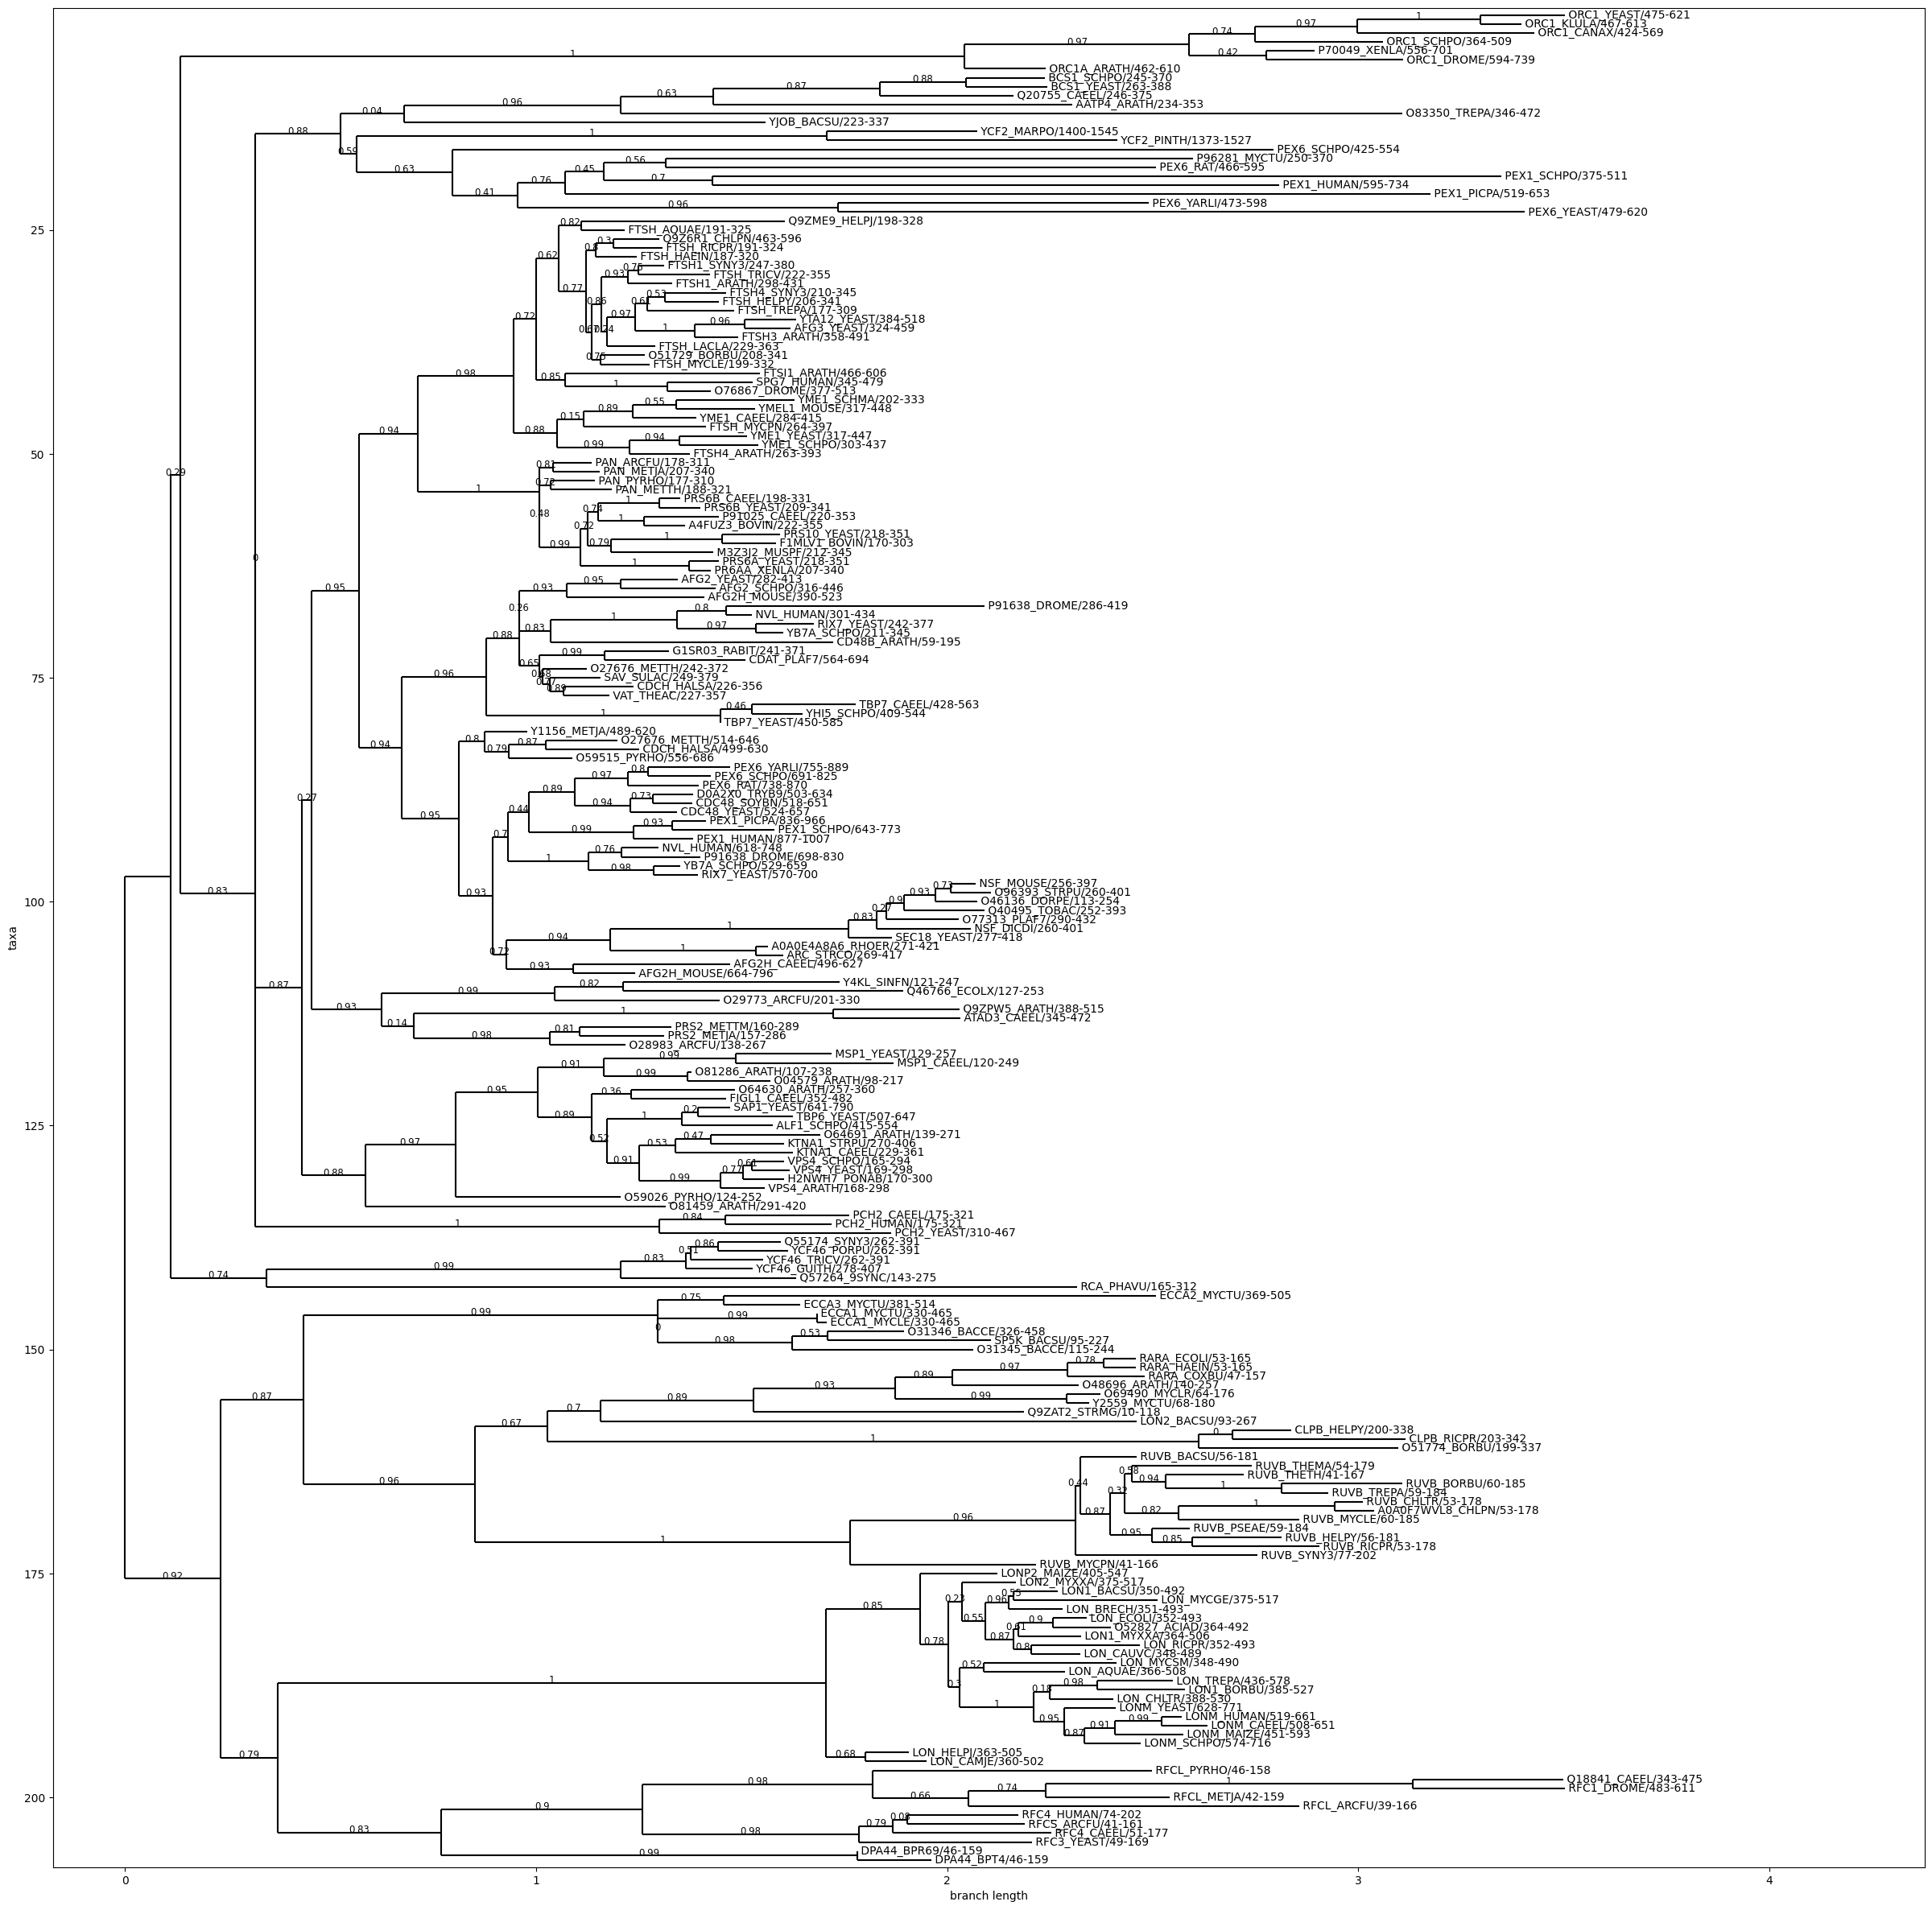

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,30))
Phylo.draw(tree, axes = ax)

In [11]:
MSA_gen_obj = Creation_MSA_Generation_MSA1b_Cython(MSA = all_seqs,full_tree=tree,full_tree_path=tree_path)

In [13]:
MSA_gen_obj.original_MSA[0][0]

'PCH2_YEAST/310-467'

In [ ]:
t1 = time()
new_MSA = MSA_gen_obj.msa_tree_phylo(tree_100.clade,flip_before_start=0, method="minimal", masked=True, context_type="dynamic")
t2 = time()

In [ ]:
t1 = time()
new_MSA = MSA_gen_obj.msa_tree_phylo_chunked(total_sequences=100,sequences_per_iteration=2,method="minimal", masked=False)
t2 = time()

In [ ]:
import pstats
from pstats import SortKey
p = pstats.Stats('cProfile_stats')
p.strip_dirs().sort_stats('cumtime').print_stats()

In [ ]:
accepted_probs = np.load("accepted_probs.npy")
orig_probs = np.load("orig_probs.npy")
probs_ratio = np.load("probs_ratio.npy")

all_probs_df = pd.DataFrame({"accepted_probs":accepted_probs, "orig_probs":orig_probs, "probs_ratio":probs_ratio})

In [ ]:
all_probs_df

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols = 1, figsize = (10,15))

all_probs_df.hist("accepted_probs",bins = 40, ax = axes[0])
all_probs_df.hist("orig_probs",bins = 40, ax = axes[1])
all_probs_df.loc[all_probs_df["probs_ratio"] < 1, :].hist("probs_ratio",bins = 40, ax = axes[2])


In [ ]:
all_probs_df.loc[all_probs_df["probs_ratio"] < 1, :]

In [ ]:
all_probs_df.describe()

In [ ]:
# 29.90259865919749 - using rand() C function (minimal)
# 35.093829254309334 - using np.random.uniform (minimal)
# 29.68756223519643 - using full model instead of msa_light and msa_lm_head (minimal)
# 31.15256113608678 - using full model with cdivision (minimal)
# 26.35336556037267 - using divided model with cdivision (minimal)
# 26.2116673151652 - using divided model with cdivision (full)
# 317.65937532981235 - using divided model with cdivision (full) and 100 sequences
# 829 - using standard model and minimal-masking mode with 100 sequences- 
# 26.54462937116623 using standard model and "reducing, randomly sampled context" to generate 100 seqs along big tree